# Employee retention data challenge

Employee turn-over is a very costly problem for companies. The cost of replacing an employee if often larger than 100K USD, taking into account the time spent to interview and find a replacement, placement fees, sign-on bonuses and the loss of productivity for several months.

In this challenge, you have a data set with info about the employees and have to predict when employees are going to quit by understanding the main drivers of employee churn. We have data about all employees who joined from 2011/01/24 to 2015/12/13. For each employee, we also know if they are still at the company as of 2015/12/13 or they have quit. Beside that, we have general info about the employee, such as avg salary during her tenure, dept, and yrs of experience.

### Goals: 

1. Understand the main drivers of employee churn
2. Develop a predictive model to predict who is most likely to churn

# Importing packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Loading the dataset

In [2]:
# Importing raw data set which I wont change
df_raw = pd.read_csv('~/Data/employee_retention_data.csv')

# Will work off of df
df = pd.read_csv('~/Data/employee_retention_data.csv')

In [3]:
# Quick look at the data
df.head(3)

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,quit_yn,end_date
0,13021.0,7,customer_service,28,89000.0,3/24/14,10/30/15,1,10/30/15
1,825355.0,7,marketing,20,183000.0,4/29/13,4/4/14,1,4/4/14
2,927315.0,4,marketing,14,101000.0,10/13/14,NaN,0,12/13/15


Note that I've added a few helpful columns here: 'quit_yn' and 'end_date'

## Going to get durations for each subject

### First, a look at the different data types in the dataset

In [4]:
# What are the different data types?
df.dtypes

employee_id    float64
company_id       int64
dept            object
seniority        int64
salary         float64
join_date       object
quit_date       object
quit_yn          int64
end_date        object
dtype: object

Note that the date related columns are not treated like dates right now

### Converting dates into appropriate data types

In [5]:
# Converting the data into datetime 
df['JOIN_DATE'] = pd.to_datetime(df['join_date'])
df['QUIT_DATE'] = pd.to_datetime(df['quit_date'])
df['END_DATE'] = pd.to_datetime(df['end_date'])

### Getting the duration of time the employee was at the company

In [6]:
df['Duration'] = df['END_DATE'] - df['JOIN_DATE'] 

In [7]:
# Check that we now have correct data types
df.dtypes

employee_id            float64
company_id               int64
dept                    object
seniority                int64
salary                 float64
join_date               object
quit_date               object
quit_yn                  int64
end_date                object
JOIN_DATE       datetime64[ns]
QUIT_DATE       datetime64[ns]
END_DATE        datetime64[ns]
Duration       timedelta64[ns]
dtype: object

Now they are treated like datetimes

In [8]:
# Any missing values?
df.isnull().sum()

employee_id        0
company_id         0
dept               0
seniority          0
salary             0
join_date          0
quit_date      11192
quit_yn            0
end_date           0
JOIN_DATE          0
QUIT_DATE      11192
END_DATE           0
Duration           0
dtype: int64

Only missing values are due to the employees who didn't quit... Because I'll create a quit varibale with censored cases this wont be an issue

# Let's look at employee survival at different companies

### Defining quitting cases and sensored cases

Making use of the extra column I created in excel: quit_yn

In [9]:
# defining events: True = quit, False = still at job
events = df['quit_yn'] == 1

# Have a look at 1st 3 rows
events[:3]

0     True
1     True
2    False
Name: quit_yn, dtype: bool

### Defining survivial times

Making use of the Durations column I generated

In [10]:
# Converting the datetime object to # of days
survival_times = df['Duration'].astype('timedelta64[D]')

# Have a look at 1st 3 rows
survival_times[:3]

0    585.0
1    340.0
2    426.0
Name: Duration, dtype: float64

### Adding these useful new measures back to the main data frame for later use

In [11]:
# Add the Survive variable to df
df['Survive'] = events

In [12]:
# Add the survival times variable to df
df['Times'] = survival_times

In [13]:
# Having a look at the dataframe
df.head(3)

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,quit_yn,end_date,JOIN_DATE,QUIT_DATE,END_DATE,Duration,Survive,Times
0,13021.0,7,customer_service,28,89000.0,3/24/14,10/30/15,1,10/30/15,2014-03-24,2015-10-30,2015-10-30,585 days,True,585.0
1,825355.0,7,marketing,20,183000.0,4/29/13,4/4/14,1,4/4/14,2013-04-29,2014-04-04,2014-04-04,340 days,True,340.0
2,927315.0,4,marketing,14,101000.0,10/13/14,NaN,0,12/13/15,2014-10-13,NaT,2015-12-13,426 days,False,426.0


### Importing the package for survival analysi

In [14]:
from lifelines import KaplanMeierFitter

### Let's look at the overall patter of survival across all companies, departments, pay grades, and levels of senority

This is the highest level picture of the data

In [15]:
# defing the function
kmf = KaplanMeierFitter()

#Add parameters in to fit the actual model
kmf.fit(survival_times, event_observed=events)

<lifelines.KaplanMeierFitter: fitted with 24702 observations, 11192 censored>

### Overall Survival for all employees acorss all variable

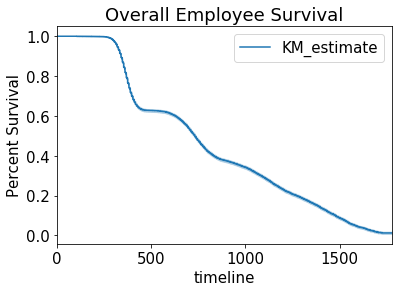

In [16]:
# Plot the survivial curve
plt.rcParams.update({'font.size': 15})
kmf.plot()
plt.ylabel('Percent Survival')
plt.title('Overall Employee Survival')

Out of curiosity, what do the durations of employment look like? Does it make sense given this survival curve?

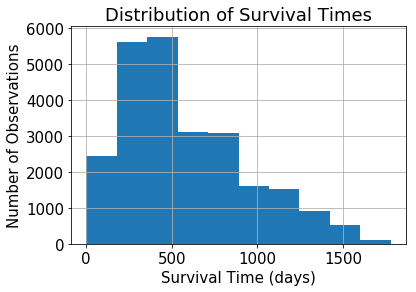

In [17]:
#Plot distribution of employee working durations
df['Times'].hist()
plt.xlabel('Survival Time (days)')
plt.ylabel('Number of Observations')
plt.title('Distribution of Survival Times')

Most employees work at a company for between 250-500 days which corresponds to the what the survival function suggests

## Takeaway number 1: 

Without seperating anything out ~ 100% of employees stay for around 1yr and then there is a sharp decline after the 1st year where ~ 40% of employees leave. After this, there is a relativley stable rate of leaving over the next several years of about 20% / year

# Comparing survival rates across different companies

In [18]:
# Brute force: seperating data out for different companies:
df_1 = df[df['company_id'] == 1]
df_2 = df[df['company_id'] == 2]
df_3 = df[df['company_id'] == 3]
df_4 = df[df['company_id'] == 4]
df_5 = df[df['company_id'] == 5]
df_6 = df[df['company_id'] == 6]
df_7 = df[df['company_id'] == 7]
df_8 = df[df['company_id'] == 8]
df_9 = df[df['company_id'] == 9]
df_10 = df[df['company_id'] == 10]
df_11 = df[df['company_id'] == 11]
df_12 = df[df['company_id'] == 12]

### defining event and survival time variables

In [19]:
events1 = df_1['Survive']
events2 = df_2['Survive']
events3 = df_3['Survive']
events4 = df_4['Survive']
events5 = df_5['Survive']
events6 = df_6['Survive']
events7 = df_7['Survive']
events8 = df_8['Survive']
events9 = df_9['Survive']
events10 = df_10['Survive']
events11 = df_11['Survive']
events12 = df_12['Survive']

times1 = df_1['Times']
times2 = df_2['Times']
times3 = df_3['Times']
times4 = df_4['Times']
times5 = df_5['Times']
times6 = df_6['Times']
times7 = df_7['Times']
times8 = df_8['Times']
times9 = df_9['Times']
times10 = df_10['Times']
times11 = df_11['Times']
times12 = df_12['Times']

In [20]:
kmf_1 = KaplanMeierFitter()
kmf_2 = KaplanMeierFitter()
kmf_3 = KaplanMeierFitter()
kmf_4 = KaplanMeierFitter()
kmf_5 = KaplanMeierFitter()
kmf_6 = KaplanMeierFitter()
kmf_7 = KaplanMeierFitter()
kmf_8 = KaplanMeierFitter()
kmf_9 = KaplanMeierFitter()
kmf_10 = KaplanMeierFitter()
kmf_11 = KaplanMeierFitter()
kmf_12 = KaplanMeierFitter()

### Comparing survival curves at different companies

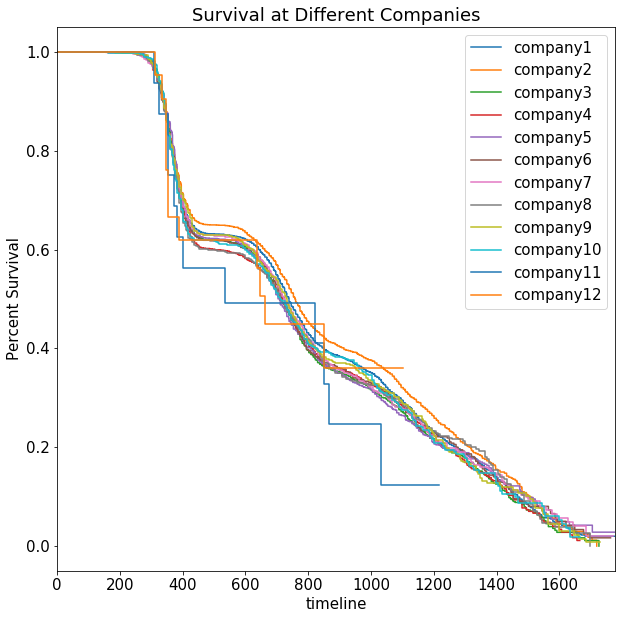

In [21]:
plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 15})
ax = plt.subplot(111)
ax = kmf_1.fit(times1, event_observed=events1,label='company1').plot(ax=ax,ci_show=False)
ax = kmf_2.fit(times2, event_observed=events2,label='company2').plot(ax=ax,ci_show=False)
ax = kmf_3.fit(times3, event_observed=events3,label='company3').plot(ax=ax,ci_show=False)
ax = kmf_4.fit(times4, event_observed=events4,label='company4').plot(ax=ax,ci_show=False)
ax = kmf_5.fit(times5, event_observed=events5,label='company5').plot(ax=ax,ci_show=False)
ax = kmf_6.fit(times6, event_observed=events6,label='company6').plot(ax=ax,ci_show=False)
ax = kmf_7.fit(times7, event_observed=events7,label='company7').plot(ax=ax,ci_show=False)
ax = kmf_8.fit(times8, event_observed=events8,label='company8').plot(ax=ax,ci_show=False)
ax = kmf_9.fit(times9, event_observed=events9,label='company9').plot(ax=ax,ci_show=False)
ax = kmf_10.fit(times10, event_observed=events10,label='company10').plot(ax=ax,ci_show=False)
ax = kmf_11.fit(times11, event_observed=events11,label='company11').plot(ax=ax,ci_show=False)
ax = kmf_12.fit(times12, event_observed=events12,label='company12').plot(ax=ax,ci_show=False)
plt.ylabel('Percent Survival')
plt.title('Survival at Different Companies')


### Takeaway Number 2:

Overall, threre is very little difference in the overall pattern of survival across the different companies... All follow the same pattern described about (~40% employee loss after 1 year)

Most discrepant companies are the ones with the fewest employees in this dataset, # 11 and 12 (See histogram below)

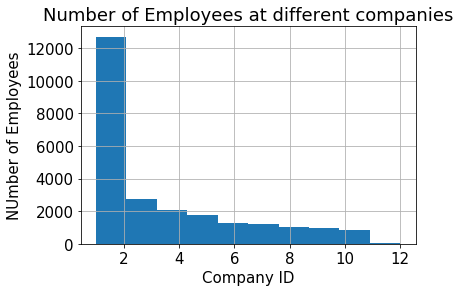

In [22]:
df['company_id'].hist()
plt.xlabel('Company ID')
plt.ylabel('NUmber of Employees')
plt.title('Number of Employees at different companies')

# Comparing survival rates across different departments

### Getting data for each different department

In [23]:
# Brute force 
df_customer_service = df[df['dept'] == 'customer_service']
df_data_science = df[df['dept'] == 'data_science']
df_design = df[df['dept'] == 'design']
df_engineer = df[df['dept'] == 'engineer']
df_marketing = df[df['dept'] == 'marketing']
df_sales = df[df['dept'] == 'sales']

In [24]:
# Defining events and survival times
events_cust = df_customer_service['Survive']
events_data = df_data_science['Survive']
events_design = df_design['Survive']
events_engineer = df_engineer['Survive']
events_marketing = df_marketing['Survive']
events_sales = df_sales['Survive']

times_cust = df_customer_service['Times']
times_data = df_data_science['Times']
times_design = df_design['Times']
times_engineer = df_engineer['Times']
times_marketing = df_marketing['Times']
times_sales = df_sales['Times']

In [25]:
# Defining the model
kmf_cust = KaplanMeierFitter()
kmf_data = KaplanMeierFitter()
kmf_design = KaplanMeierFitter()
kmf_engineer = KaplanMeierFitter()
kmf_marketing = KaplanMeierFitter()
kmf_sales = KaplanMeierFitter()

### Plotting survival by department type

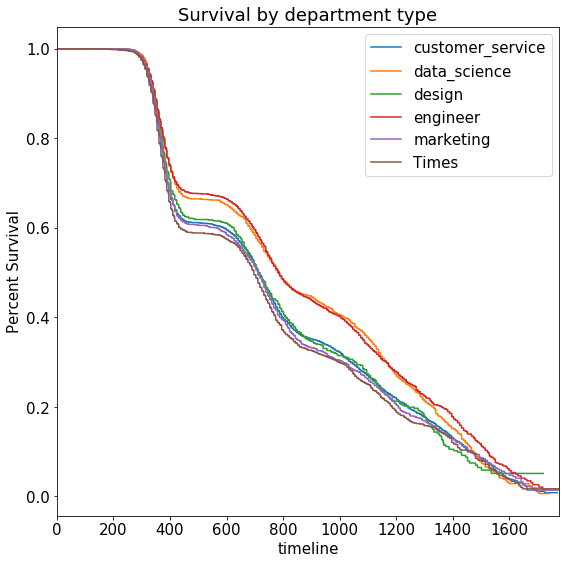

In [26]:
plt.figure(figsize=(9,9))
ax = plt.subplot(111)

ax = kmf_cust.fit(times_cust, event_observed = events_cust, label = 'customer_service').plot(ax=ax,ci_show=False)
ax = kmf_data.fit(times_data, event_observed = events_data,label = 'data_science').plot(ax=ax,ci_show=False)
ax = kmf_design.fit(times_design, event_observed = events_design,label = 'design').plot(ax=ax,ci_show=False)
ax = kmf_engineer.fit(times_engineer, event_observed = events_engineer,label = 'engineer').plot(ax=ax,ci_show=False)
ax = kmf_marketing.fit(times_marketing, event_observed = events_marketing,label = 'marketing').plot(ax=ax,ci_show=False)
ax = kmf_sales.fit(times_sales, event_observed = events_sales,label = 'Times').plot(ax=ax,ci_show=False)

plt.ylabel('Percent Survival')
plt.title('Survival by department type')

### Takeaway Number 3:

All departments follow the same overall patter described above. Datascience and engineering loose slightly less employees during the 1st year drop off, but then rates of loss are ~ to other departments thereafter 

# Comparing Survival Rates at different senority levels

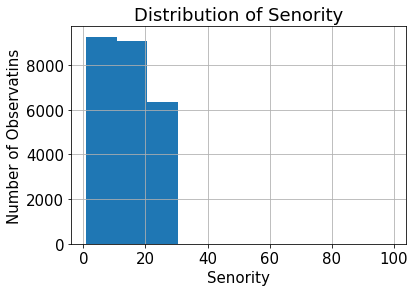

In [27]:
df['seniority'].hist()
plt.ylabel('Number of Observatins')
plt.xlabel('Senority')
plt.title('Distribution of Senority')

Must be a few outliers values here...

In [28]:
df['seniority'].describe()

count    24702.000000
mean        14.127803
std          8.089520
min          1.000000
25%          7.000000
50%         14.000000
75%         21.000000
max         99.000000
Name: seniority, dtype: float64

##  Breaking senority up in 5 year buckets

In [29]:
# getting the data
df_sen0_5 = df[(df['seniority'] > 0) & (df['seniority'] <=5)]
df_sen5_10 = df[(df['seniority'] > 5) & (df['seniority'] <=10)]
df_sen10_15 = df[(df['seniority'] > 10) & (df['seniority'] <=15)]
df_sen15_20 = df[(df['seniority'] > 15) & (df['seniority'] <=20)]
df_sen20_25 = df[(df['seniority'] > 20) & (df['seniority'] <=25)]
df_sen25_up = df[df['seniority'] > 25]

In [30]:
# Defining events and survival times
events_sen0_5 = df_sen0_5['Survive']
events_sen5_10 = df_sen5_10['Survive']
events_sen10_15 = df_sen10_15['Survive']
events_sen15_20 = df_sen15_20['Survive']
events_sen20_25 = df_sen20_25['Survive']
events_sen25_up = df_sen25_up['Survive']

times_sen0_5 = df_sen0_5['Times']
times_sen5_10 = df_sen5_10['Times']
times_sen10_15 = df_sen10_15['Times']
times_sen15_20 = df_sen15_20['Times']
times_sen20_25 = df_sen20_25['Times']
times_sen25_up = df_sen25_up['Times']

In [31]:
#Defining the models
kmf_sen0_5 = KaplanMeierFitter()
kmf_sen5_10 = KaplanMeierFitter()
kmf_sen10_15 = KaplanMeierFitter()
kmf_sen15_20 = KaplanMeierFitter()
kmf_sen20_25 = KaplanMeierFitter()
kmf_sen25_up = KaplanMeierFitter()

### Comparing survival at different senority levels

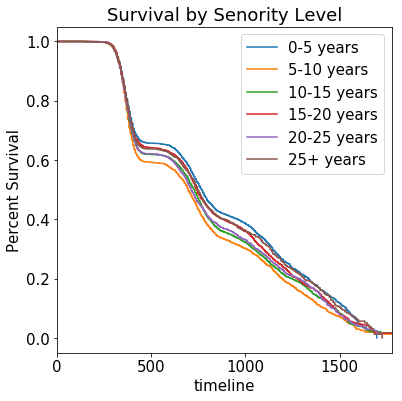

In [32]:
# Plotting the data
plt.figure(figsize=(6,6))
ax = plt.subplot(111)

ax = kmf_sen0_5.fit(times_sen0_5, event_observed = events_sen0_5, label = '0-5 years').plot(ax=ax,ci_show=False)
ax = kmf_sen5_10.fit(times_sen5_10, event_observed = events_sen5_10,label = '5-10 years').plot(ax=ax,ci_show=False)
ax = kmf_sen10_15.fit(times_sen10_15, event_observed = events_sen10_15,label = '10-15 years').plot(ax=ax,ci_show=False)
ax = kmf_sen15_20.fit(times_sen15_20, event_observed = events_sen15_20,label = '15-20 years').plot(ax=ax,ci_show=False)
ax = kmf_sen20_25.fit(times_sen20_25, event_observed = events_sen20_25,label = '20-25 years').plot(ax=ax,ci_show=False)
ax = kmf_sen25_up.fit(times_sen25_up, event_observed = events_sen25_up,label = '25+ years').plot(ax=ax,ci_show=False)

plt.ylabel('Percent Survival')
plt.title('Survival by Senority Level')

## Takeaway Number 4:

Still, the overall patter as described above still holds regardless of senority. All senority levels have highly similar 1st year attrition rates, then they differ slightly thereafter

# Comparing Survival rates across different salary brakets

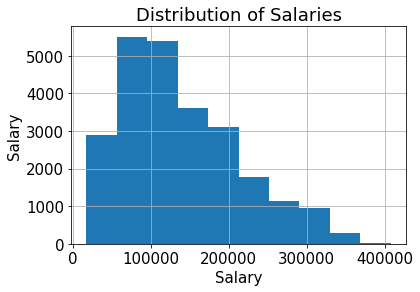

In [33]:
df['salary'].hist()
plt.xlabel('Salary')
plt.title('Distribution of Salaries')
plt.ylabel('Salary')

In [34]:
df['salary'].describe()

count     24702.000000
mean     138183.345478
std       76058.184573
min       17000.000000
25%       79000.000000
50%      123000.000000
75%      187000.000000
max      408000.000000
Name: salary, dtype: float64

### Going to break salary up in 100K brakets

In [35]:
# Getting the data
df_sal0_100 = df[(df['salary'] > 0) & (df['salary'] <=100000)]
df_sal100_200 = df[(df['salary'] > 100000) & (df['salary'] <=200000)]
df_sal200_300 = df[(df['salary'] > 200000) & (df['salary'] <=300000)]
df_sal300_up = df[df['salary'] > 300000]

In [36]:
# Defining events and survival times
events_sal0_100 = df_sal0_100['Survive']
events_sal100_200 = df_sal100_200['Survive']
events_sal200_300 = df_sal200_300['Survive']
events_sal300_up = df_sal300_up['Survive']

times_sal0_100 = df_sal0_100['Times']
times_sal100_200 = df_sal100_200['Times']
times_sal200_300 = df_sal200_300['Times']
times_sal300_up = df_sal300_up['Times']

In [37]:
#Defining the model
kmf_sal0_100 = KaplanMeierFitter()
kmf_sal100_200 = KaplanMeierFitter()
kmf_sal200_300 = KaplanMeierFitter()
kmf_sal300_up = KaplanMeierFitter()

### Comparing survival curves across different salary brackets

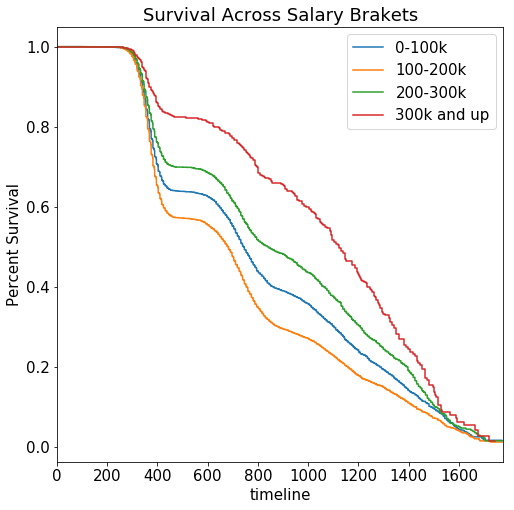

In [38]:
#Plotting the data
plt.figure(figsize=(8,8))
ax = plt.subplot(111)

ax = kmf_sal0_100.fit(times_sal0_100, event_observed = events_sal0_100, label = '0-100k').plot(ax=ax,ci_show=False)
ax = kmf_sal100_200.fit(times_sal100_200, event_observed = events_sal100_200,label = '100-200k').plot(ax=ax,ci_show=False)
ax = kmf_sal200_300.fit(times_sal200_300, event_observed = events_sal200_300,label = '200-300k').plot(ax=ax,ci_show=False)
ax = kmf_sal300_up.fit(times_sal300_up, event_observed = events_sal300_up,label = '300k and up').plot(ax=ax,ci_show=False)

plt.ylabel('Percent Survival')
plt.title('Survival Across Salary Brakets')

## Takeaway: Salary has biggest impact on survival rates

This factor above all of the others seems to impact rates of attrition after the first year. Highest paid employees don't leave at the same rates as others and 100K-200K leave at the highest rate compared to others in the first year

# = = = = = = = = = 
# Developing a predictive model

In [39]:
df.head(4)

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,quit_yn,end_date,JOIN_DATE,QUIT_DATE,END_DATE,Duration,Survive,Times
0,13021.0,7,customer_service,28,89000.0,3/24/14,10/30/15,1,10/30/15,2014-03-24,2015-10-30,2015-10-30,585 days,True,585.0
1,825355.0,7,marketing,20,183000.0,4/29/13,4/4/14,1,4/4/14,2013-04-29,2014-04-04,2014-04-04,340 days,True,340.0
2,927315.0,4,marketing,14,101000.0,10/13/14,NaN,0,12/13/15,2014-10-13,NaT,2015-12-13,426 days,False,426.0
3,662910.0,7,customer_service,20,115000.0,5/14/12,6/7/13,1,6/7/13,2012-05-14,2013-06-07,2013-06-07,389 days,True,389.0


## 1) Cleaning the data

### Quick overview of data

In [40]:
df.describe()

,employee_id,company_id,seniority,salary,quit_yn,Duration,Times
count,24702.000000,24702.000000,24702.000000,24702.000000,24702.000000,24702,24702.000000
mean,501604.403530,3.426969,14.127803,138183.345478,0.546919,574 days 07:39:28.812241,574.319083
std,288909.026101,2.700011,8.089520,76058.184573,0.497804,361 days 14:13:01.578145,361.592379
min,36.000000,1.000000,1.000000,17000.000000,0.000000,3 days 00:00:00,3.000000
25%,250133.750000,1.000000,7.000000,79000.000000,0.000000,333 days 00:00:00,333.000000
50%,500793.000000,2.000000,14.000000,123000.000000,1.000000,424 days 00:00:00,424.000000
75%,753137.250000,5.000000,21.000000,187000.000000,1.000000,781 days 00:00:00,781.000000
max,999969.000000,12.000000,99.000000,408000.000000,1.000000,1777 days 00:00:00,1777.000000


Seems odd that an employee is 99.. possible but seems like a mistake

In [41]:
# What are the different values for senority?
df['seniority'].unique()

array([28, 20, 14, 23, 21,  4,  7, 13, 17,  1, 10,  6, 19, 15, 26, 27,  5,
       18, 16, 25,  9,  2, 29,  3,  8, 22, 24, 12, 11, 98, 99])

### Creating a record at this point in time before changing the data frame

In [42]:
df_record1 = df

In [43]:
# Remove rows with wrong values for seniority:

wrong_sen_mask = df['seniority'] > 70

In [44]:
df.shape

(24702, 15)

### Dropping employees with error senority

In [45]:
df.drop(df[wrong_sen_mask].index,axis = 0,inplace=True)

In [46]:
df.shape

(24700, 15)

Dropped 2 employees

In [47]:
df.columns

Index(['employee_id', 'company_id', 'dept', 'seniority', 'salary', 'join_date',
       'quit_date', 'quit_yn', 'end_date', 'JOIN_DATE', 'QUIT_DATE',
       'END_DATE', 'Duration', 'Survive', 'Times'],
      dtype='object')

## Cox-proportional hazard model

In [49]:
# 1 for those who quit during the monitoring time and 0 for those who did not:
df['quit'] = (pd.notnull(df['quit_date'])).astype('int')

# Duration of survival:
df['days'] = df['Times']

# Hot one encoding of departments:
pd.unique(df.dept)

array(['customer_service', 'marketing', 'data_science', 'engineer',
       'sales', 'design'], dtype=object)

### One hot encoding by hand

In [50]:
df['customer_service'] = (df['dept'] == 'customer_service').astype('int')
df['marketing'] = (df['dept'] == 'marketing').astype('int')
df['data_science'] = (df['dept'] == 'data_science').astype('int')
df['engineer'] = (df['dept'] == 'engineer').astype('int')
df['sales'] = (df['dept'] == 'sales').astype('int')
df['design'] = (df['dept'] == 'design').astype('int')

### Normalizing salary and senority data

In [51]:
norm_sal = (df['salary']-df['salary'].min())/(df['salary'].max()-df['salary'].min())
norm_sen = (df['seniority']-df['seniority'].min())/(df['seniority'].max()-df['seniority'].min())
norm_times = (df['Times']-df['Times'].min())/(df['Times'].max()-df['Times'].min())

emp_norm = df.copy()
emp_norm['salary'] = norm_sal
emp_norm['seniority'] = norm_sen
emp_norm['Times'] = norm_times

# Drop the unnecessary columns: 
emp_norm.drop(['employee_id','company_id','dept','join_date','quit_date'],axis = 1,inplace = True)

### Creating new interaction varibales: Time x Salary, Time x Senority, Salary x Senority

In [52]:
emp_norm['Time_Sal'] = emp_norm['Times'] * emp_norm['salary']
emp_norm['Time_Sen'] = emp_norm['Times'] * emp_norm['seniority']
emp_norm['Sal_Sen'] = emp_norm['salary'] * emp_norm['seniority']

### Plotting rescaled salary and senority variables

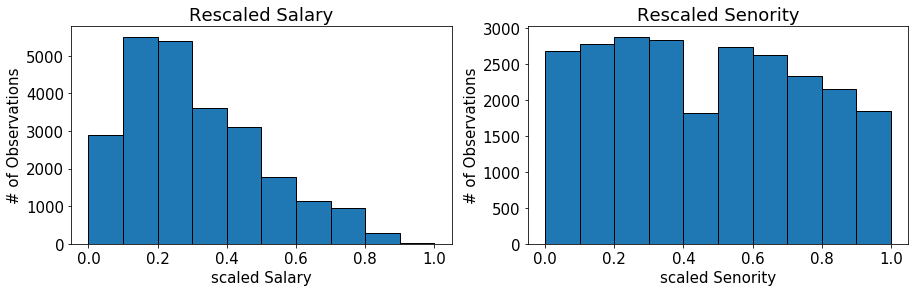

In [53]:
plt.figure(figsize=(15, 4))
plt.rcParams.update({'font.size': 15})

plt.subplot(1,2,1)
plt.hist(emp_norm['salary'],10,edgecolor='black')
plt.title('Rescaled Salary')
plt.xlabel('scaled Salary')
plt.ylabel('# of Observations')

plt.subplot(1,2,2)
plt.hist(emp_norm['seniority'],10,edgecolor='black')
plt.title('Rescaled Senority')
plt.xlabel('scaled Senority')
plt.ylabel('# of Observations')

### Plotting orignal salary and senority variables

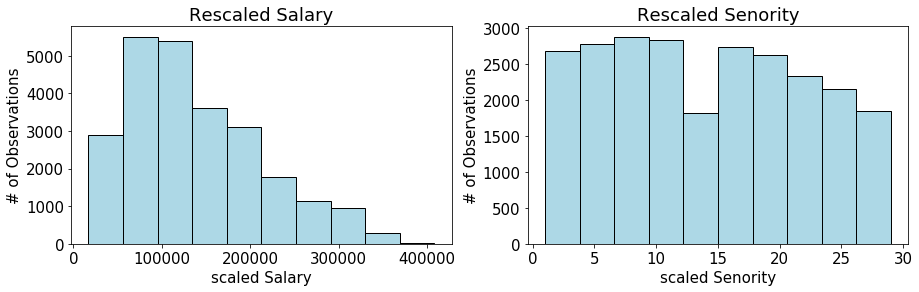

In [54]:
plt.figure(figsize=(15, 4))
plt.rcParams.update({'font.size': 15})

plt.subplot(1,2,1)
plt.hist(df['salary'],10,color='lightblue',edgecolor='black')
plt.title('Rescaled Salary')
plt.xlabel('scaled Salary')
plt.ylabel('# of Observations')

plt.subplot(1,2,2)
plt.hist(df['seniority'],10,color='lightblue',edgecolor='black')
plt.title('Rescaled Senority')
plt.xlabel('scaled Senority')
plt.ylabel('# of Observations')

### How do times x salary/senority engineered features look?

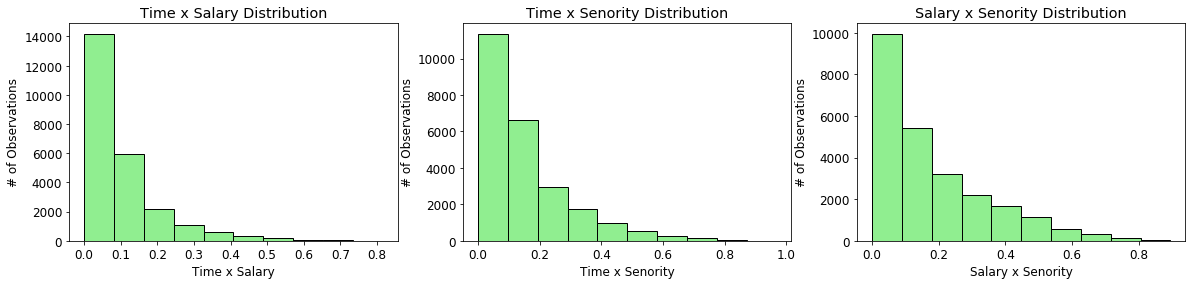

In [55]:
plt.figure(figsize=(20, 4))
plt.rcParams.update({'font.size': 12})

plt.subplot(1,3,1)
plt.hist(emp_norm['Time_Sal'],10,color='lightgreen',edgecolor='black')
plt.title('Time x Salary Distribution')
plt.xlabel('Time x Salary')
plt.ylabel('# of Observations')

plt.subplot(1,3,2)
plt.hist(emp_norm['Time_Sen'],10,color='lightgreen',edgecolor='black')
plt.title('Time x Senority Distribution')
plt.xlabel('Time x Senority')
plt.ylabel('# of Observations')

plt.subplot(1,3,3)
plt.hist(emp_norm['Sal_Sen'],10,color='lightgreen',edgecolor='black')
plt.title('Salary x Senority Distribution')
plt.xlabel('Salary x Senority')
plt.ylabel('# of Observations')

## Cox proportional hazzard model

In [56]:
emp_norm.head()

,seniority,salary,quit_yn,end_date,JOIN_DATE,QUIT_DATE,END_DATE,Duration,Survive,Times,...,days,customer_service,marketing,data_science,engineer,sales,design,Time_Sal,Time_Sen,Sal_Sen
0,0.964286,0.184143,1,10/30/15,2014-03-24,2015-10-30,2015-10-30,585 days,True,0.328072,...,585.0,1,0,0,0,0,0,0.060412,0.316355,0.177567
1,0.678571,0.424552,1,4/4/14,2013-04-29,2014-04-04,2014-04-04,340 days,True,0.189966,...,340.0,0,1,0,0,0,0,0.080651,0.128906,0.288089
2,0.464286,0.214834,0,12/13/15,2014-10-13,NaT,2015-12-13,426 days,False,0.238444,...,426.0,0,1,0,0,0,0,0.051226,0.110706,0.099744
3,0.678571,0.250639,1,6/7/13,2012-05-14,2013-06-07,2013-06-07,389 days,True,0.217587,...,389.0,1,0,0,0,0,0,0.054536,0.147649,0.170077
4,0.785714,0.662404,1,8/22/14,2011-10-17,2014-08-22,2014-08-22,1040 days,True,0.584555,...,1040.0,0,0,1,0,0,0,0.387211,0.459293,0.520460


In [57]:
#emp_norm['Times'] = emp_norm['Times'].astype('int')
#emp_norm.head()

In [58]:
emp_norm.columns

Index(['seniority', 'salary', 'quit_yn', 'end_date', 'JOIN_DATE', 'QUIT_DATE',
       'END_DATE', 'Duration', 'Survive', 'Times', 'quit', 'days',
       'customer_service', 'marketing', 'data_science', 'engineer', 'sales',
       'design', 'Time_Sal', 'Time_Sen', 'Sal_Sen'],
      dtype='object')

In [59]:
emp_norm = emp_norm.drop(['quit_yn','end_date', 'JOIN_DATE', 'QUIT_DATE',
       'END_DATE', 'Duration', 'Survive','days'],axis=1)
emp_norm.head(3)

,seniority,salary,Times,quit,customer_service,marketing,data_science,engineer,sales,design,Time_Sal,Time_Sen,Sal_Sen
0,0.964286,0.184143,0.328072,1,1,0,0,0,0,0,0.060412,0.316355,0.177567
1,0.678571,0.424552,0.189966,1,0,1,0,0,0,0,0.080651,0.128906,0.288089
2,0.464286,0.214834,0.238444,0,0,1,0,0,0,0,0.051226,0.110706,0.099744


In [60]:
# Checking for any missing values
emp_norm.isnull().sum()

seniority           0
salary              0
Times               0
quit                0
customer_service    0
marketing           0
data_science        0
engineer            0
sales               0
design              0
Time_Sal            0
Time_Sen            0
Sal_Sen             0
dtype: int64

### Cox Proportional Hazard Model - with Time interaction variables and scaled data

In [61]:
from lifelines import CoxPHFitter

cph = CoxPHFitter()
cph.fit(emp_norm, duration_col='Times', event_col='quit')

cph.print_summary()  # access the results using cph.summary

n=24700, number of events=13508

                     coef  exp(coef)    se(coef)        z      p    lower 0.95   upper 0.95     
seniority          6.1746   480.3987      0.1025  60.2507 0.0000        5.9737       6.3755  ***
salary             9.6850 16075.0847      0.1900  50.9717 0.0000        9.3125      10.0575  ***
customer_service  -5.9569     0.0026 840067.4958  -0.0000 1.0000 -1646870.0055 1646858.0917     
marketing         -5.8655     0.0028 840067.4958  -0.0000 1.0000 -1646869.9141 1646858.1831     
data_science      -5.9573     0.0026 840067.4958  -0.0000 1.0000 -1646870.0059 1646858.0913     
engineer          -5.9462     0.0026 840067.4958  -0.0000 1.0000 -1646869.9948 1646858.1024     
sales             -5.8233     0.0030 840067.4958  -0.0000 1.0000 -1646869.8719 1646858.2253     
design            -5.9030     0.0027 840067.4958  -0.0000 1.0000 -1646869.9516 1646858.1455     
Time_Sal         -14.3157     0.0000      0.3389 -42.2407 0.0000      -14.9800     -13.6513  *

### Cox Proportional Hazard Model - without Time interaction variables

In [62]:
emp_norm1 = emp_norm.drop(['Time_Sal','Time_Sen','Sal_Sen'],axis=1)
emp_norm1.head(2)

,seniority,salary,Times,quit,customer_service,marketing,data_science,engineer,sales,design
0,0.964286,0.184143,0.328072,1,1,0,0,0,0,0
1,0.678571,0.424552,0.189966,1,0,1,0,0,0,0


In [95]:
cph1 = CoxPHFitter()
cph1.fit(emp_norm1, duration_col='Times', event_col='quit')

cph1.print_summary()  # access the results using cph.summary

n=24700, number of events=13508

                    coef  exp(coef)    se(coef)       z      p   lower 0.95  upper 0.95     
seniority         0.2990     1.3486      0.0460  6.5076 0.0000       0.2090      0.3891  ***
salary           -0.7340     0.4800      0.0922 -7.9574 0.0000      -0.9148     -0.5532  ***
customer_service -3.4800     0.0308 260968.3055 -0.0000 1.0000 -511604.4195 511597.4596     
marketing        -3.3642     0.0346 260968.3055 -0.0000 1.0000 -511604.3038 511597.5753     
data_science     -3.4198     0.0327 260968.3055 -0.0000 1.0000 -511604.3594 511597.5197     
engineer         -3.4471     0.0318 260968.3055 -0.0000 1.0000 -511604.3867 511597.4924     
sales            -3.3179     0.0362 260968.3055 -0.0000 1.0000 -511604.2574 511597.6217     
design           -3.3885     0.0338 260968.3055 -0.0000 1.0000 -511604.3280 511597.5511     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.534


### Note:
Adding the interaction term variables increases the concordance rate quite a bit: 0.840 vs 0.534

## One hot encoding the company varibale

In [73]:
company_ids = pd.get_dummies(df['company_id'],prefix = 'com')
company_ids.head(5)

,com_1,com_2,com_3,com_4,com_5,com_6,com_7,com_8,com_9,com_10,com_11,com_12
0,0,0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0


### Getting company ID's on emp_norm and emp_norm1

In [74]:
# hack job of adding the company id one hot encoded data to data frame
# = = = emp_norm
emp_norm['comp_1'] = company_ids['com_1']
emp_norm['comp_2'] = company_ids['com_2']
emp_norm['comp_3'] = company_ids['com_3']
emp_norm['comp_4'] = company_ids['com_4']
emp_norm['comp_5'] = company_ids['com_5']
emp_norm['comp_6'] = company_ids['com_6']
emp_norm['comp_7'] = company_ids['com_7']
emp_norm['comp_8'] = company_ids['com_8']
emp_norm['comp_9'] = company_ids['com_9']
emp_norm['comp_10'] = company_ids['com_10']
emp_norm['comp_11'] = company_ids['com_11']
emp_norm['comp_12'] = company_ids['com_12']

# = = = emp_norm
emp_norm1['comp_1'] = company_ids['com_1']
emp_norm1['comp_2'] = company_ids['com_2']
emp_norm1['comp_3'] = company_ids['com_3']
emp_norm1['comp_4'] = company_ids['com_4']
emp_norm1['comp_5'] = company_ids['com_5']
emp_norm1['comp_6'] = company_ids['com_6']
emp_norm1['comp_7'] = company_ids['com_7']
emp_norm1['comp_8'] = company_ids['com_8']
emp_norm1['comp_9'] = company_ids['com_9']
emp_norm1['comp_10'] = company_ids['com_10']
emp_norm1['comp_11'] = company_ids['com_11']
emp_norm1['comp_12'] = company_ids['com_12']

emp_norm.head(3)

,seniority,salary,Times,quit,customer_service,marketing,data_science,engineer,sales,design,...,comp_3,comp_4,comp_5,comp_6,comp_7,comp_8,comp_9,comp_10,comp_11,comp_12
0,0.964286,0.184143,0.328072,1,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0.678571,0.424552,0.189966,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0.464286,0.214834,0.238444,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


# Developing Machine Learning Models

## Starting with all of the data

In [75]:
# Data with interaction varibales
all_data = emp_norm

# Data without interaction varibales
all_data1 = emp_norm1

### What is the number of observations... this will influence splitting into train, val, and test sets

In [76]:
print('All Data with interaction variables:',all_data.shape)
print('Data without interation variables:',all_data1.shape)

All Data with interaction variables: (24700, 25)
Data without interation variables: (24700, 22)


Let's set aside 1/3 of the data for the test set

In [77]:
24700 * 0.3

7410.0

So, ~ 7410 of the observations will be test data

## Define Feature Matrix and Target Vector with all of the data

In [78]:
X = all_data.drop(['quit'],axis=1)
y = all_data['quit']

# Without interaction variables
X1 = all_data1.drop(['quit'],axis=1)
y1 = all_data1['quit']

### Let's first get a 70-30 split of data - set the 30% aside as true test set

In [79]:
from sklearn.model_selection import train_test_split

# split the data with 70% in each set
X_train_pre, X_test, y_train_pre, y_test = train_test_split(X, y, random_state=63,
                                  train_size=0.7)

# split the data with 70% in each set
X1_train_pre, X1_test, y1_train_pre, y1_test = train_test_split(X1, y1, random_state=63,
                                  train_size=0.7)

### Checking the shapes

In [80]:
print(X_train_pre.shape)
print(X_test.shape)
print(y_train_pre.shape)
print(y_test.shape)

(17290, 24)
(7410, 24)
(17290,)
(7410,)


### Now creating real training and development sets

In [81]:
# split the data with 70% in each set
X_train, X_dev, y_train, y_dev = train_test_split(X_train_pre, y_train_pre, random_state=27,
                                  train_size=0.7)

X1_train, X1_dev, y1_train, y1_dev = train_test_split(X1_train_pre, y1_train_pre, random_state=27,
                                  train_size=0.7)

In [82]:
print(X_train.shape)
print(X_dev.shape)
print(y_train.shape)
print(y_dev.shape)

(12103, 24)
(5187, 24)
(12103,)
(5187,)


### Now I have X_train, X_dev, X_test and y_train, y_dev and y_test ready to go

# = = Model 1: Logistic Regression

### Function defining Confusion Maxtri Plot

In [83]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


### Logistic Regression Model 1

In [84]:
# Importing LogisticRegression from linear_models
from sklearn.linear_model import LogisticRegression

### Setting up and fitting the model to training data

In [85]:
# Setting up the model
log_reg = LogisticRegression(random_state=42)
log_reg1 = LogisticRegression(random_state=42)

# Fitting the model
log_reg.fit(X_train, y_train)
log_reg1.fit(X1_train, y1_train)

print("Accuracy on training set: {:.3f}".format(log_reg.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(log_reg.score(X_dev, y_dev)))

Accuracy on training set: 0.616
Accuracy on test set: 0.619


### Without the interaction terms there is very little difference

In [86]:
print("Accuracy on training set: {:.3f}".format(log_reg1.score(X1_train, y1_train)))
print("Accuracy on test set: {:.3f}".format(log_reg1.score(X1_dev, y1_dev)))

Accuracy on training set: 0.612
Accuracy on test set: 0.610


In [87]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(log_reg, X_train, y_train, cv=10)
cv_scores

array([ 0.60693642,  0.62262593,  0.61436829,  0.60033031,  0.60826446,
        0.60991736,  0.6107438 ,  0.6       ,  0.62644628,  0.61373036])

### 10 fold Cross Validation score

In [88]:
cv_scores.mean()

0.61133631978630532

Normalized confusion matrix
[[ 0.37257439  0.62742561]
 [ 0.18200837  0.81799163]]


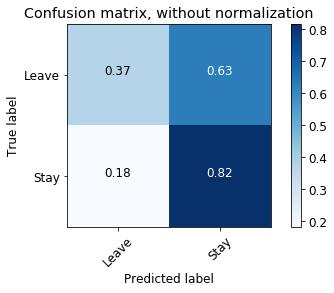

In [89]:
# Getting y_score based on model predictions of X_dev
y_score = y_score = log_reg.predict(X_dev)
y1_score = y1_score = log_reg1.predict(X1_dev)


import itertools

from sklearn.metrics import confusion_matrix
confusion_matrix(y_dev, y_score)
con_mat = confusion_matrix(y_dev, y_score)

#confusion_matrix(y1_dev, y1_score)
con_mat1 = confusion_matrix(y1_dev, y1_score)

# Plot non-normalized confusion matrix
class_names = ['Leave','Stay']

plt.figure()
plot_confusion_matrix(con_mat,classes=class_names,
                      normalize = True,
                     title='Confusion matrix, with normalization')

Confusion matrix, without normalization
[[ 864 1455]
 [ 522 2346]]


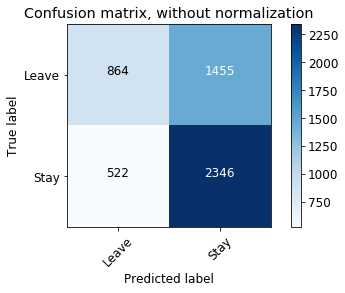

In [90]:
plt.figure()
plot_confusion_matrix(con_mat,classes=class_names,
                     title='Confusion matrix, without normalization')

### Model evaluation with interaction terms

### Precision and Recall

In [91]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

print("Precision:", precision_score(y_dev, y_score))
print("Recall:", recall_score(y_dev, y_score))

Precision: 0.617205998421
Recall: 0.817991631799


### Average Precision and Recall

In [92]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_dev, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.77


### F1 Score (geometric mean of P and R)

In [93]:
from sklearn.metrics import f1_score
print("f1 score most frequent: {:.2f}".format(
    f1_score(y_dev, y_score)))

f1 score most frequent: 0.70


### Model evaluation without interaction variables

In [94]:
print("Precision:", precision_score(y1_dev, y1_score))
print("Recall:", recall_score(y1_dev, y1_score))

Precision: 0.610328638498
Recall: 0.81589958159


In [95]:
average_precision1 = average_precision_score(y1_dev, y1_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision1))

Average precision-recall score: 0.76


In [96]:
print("f1 score most frequent: {:.2f}".format(
    f1_score(y1_dev, y1_score)))

f1 score most frequent: 0.70


### Note:
With this logistic regression model the interaction terms don't seem to be helping much, whereas they had an impact in the survival analysis

## Model 1: F1 Score = 0.70

# Model 2 - Logistic Regression with balanced classes

### What's the difference between stay and leave in this data

In [100]:
y_train.value_counts()

1    6589
0    5514
Name: quit, dtype: int64

In [101]:
5514/(5514 + 6589)

0.45558952325869617

45% of the data is churn so maybe it doesn't need to be balanced

### What about the dev set and test set?

In [102]:
y_dev.value_counts()

1    2868
0    2319
Name: quit, dtype: int64

In [103]:
2319/(2319+2868)

0.44707923655292076

45% of the dev set is churn

In [104]:
y_test.value_counts()

1    4051
0    3359
Name: quit, dtype: int64

In [105]:
3359/(3359+4051)

0.453306342780027

And 45% of the test set is churn

### Same distriutions across training, dev, and test set this is good

## Doesn't seem imbalanced enough to make a difference

# Model 3 - Decsion Tree and Random Forest

### Defining and fitting decision tree

In [106]:
# Importing the decision tree module
from sklearn.tree import DecisionTreeClassifier

# Defining the decision tree model
tree = DecisionTreeClassifier(random_state=112)

# Fitting the decision tree to the training data
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=112, splitter='best')

### Test and dev set accrucary score

In [107]:
# Printing the training and test set score:
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_dev, y_dev)))

Accuracy on training set: 1.000
Accuracy on test set: 0.866


### Defining a function to plot the feature importance

In [108]:
def plot_feature_importances(model):
    n_features = X.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    #plt.ylim(420, n_features)

### Plotting feature importance

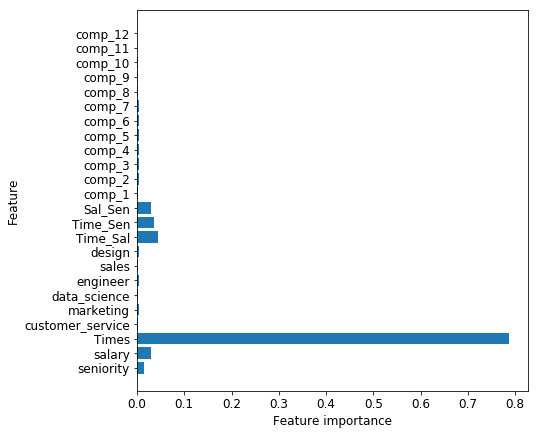

In [109]:
plt.figure(figsize=(7,7))    
plot_feature_importances(tree)

### What is the impact of Max Depth?

In [110]:
tree1 = DecisionTreeClassifier(max_depth = 3, random_state=112)
tree1.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_dev, y_dev)))

Accuracy on training set: 1.000
Accuracy on test set: 0.866


### Plotting feature importance

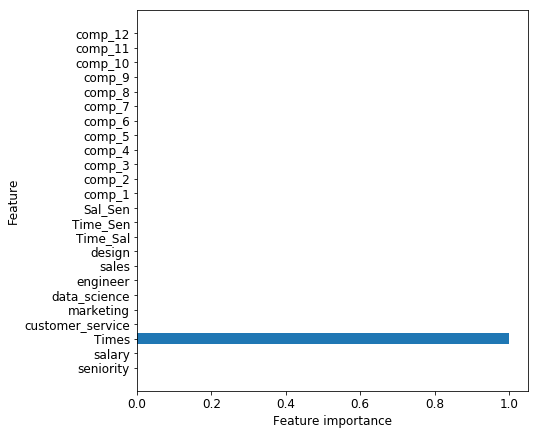

In [111]:
plt.figure(figsize=(7,7))    
plot_feature_importances(tree1)

In [112]:
tree2 = DecisionTreeClassifier(max_depth = 9, random_state=112)
tree2.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_dev, y_dev)))

Accuracy on training set: 1.000
Accuracy on test set: 0.866


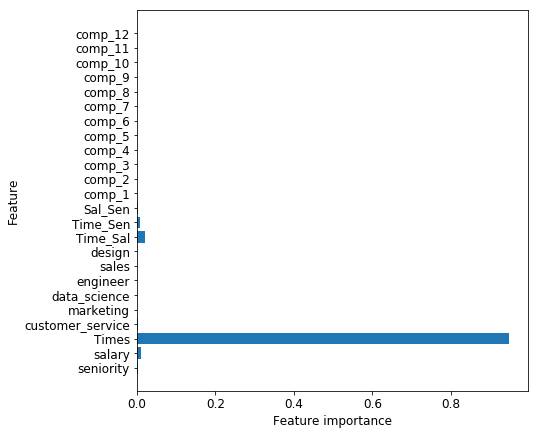

In [113]:
plt.figure(figsize=(7,7))    
plot_feature_importances(tree2)

## Random Forest

In [114]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators = 50, random_state=26)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=26,
            verbose=0, warm_start=False)

### Printing accuracy score on test and dev set

In [115]:
print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_dev, y_dev)))

Accuracy on training set: 1.000
Accuracy on test set: 0.716


### Plotting feature importance

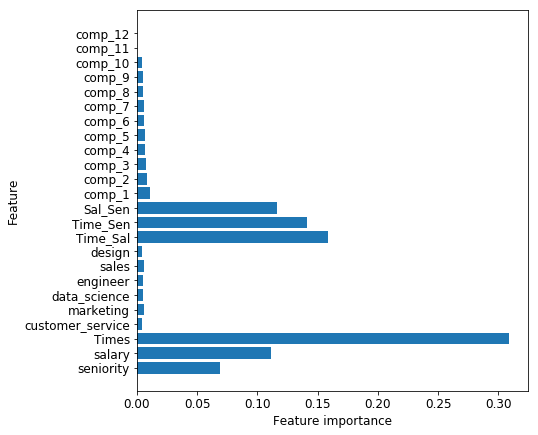

In [116]:
plt.figure(figsize=(7,7))
plot_feature_importances(forest)

### Defining y_score based on model predicions from X_dev data

In [117]:
y_score = forest.predict(X_dev)

In [118]:
# Creating the confusion matrix
confusion_matrix(y_dev, y_score)

con_mat = confusion_matrix(y_dev, y_score)

Confusion matrix, without normalization
[[1432  887]
 [ 585 2283]]


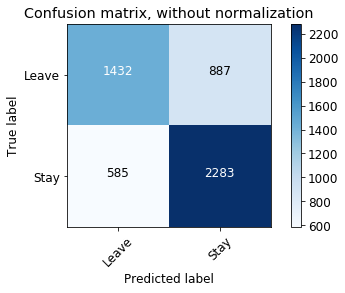

In [119]:
# Plot non-normalized confusion matrix
class_names = ['Leave','Stay']
plt.figure()
plot_confusion_matrix(con_mat,classes=class_names,
                     title='Confusion matrix, without normalization')

Normalized confusion matrix
[[ 0.61750755  0.38249245]
 [ 0.2039749   0.7960251 ]]


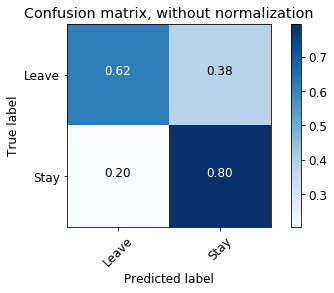

In [120]:
plt.figure()
plot_confusion_matrix(con_mat,classes=class_names,
                      normalize = True,
                     title='Confusion matrix, with normalization')

### Precision and Recall Scores

In [121]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

print("Precision:", precision_score(y_dev, y_score))
print("Recall:", recall_score(y_dev, y_score))

Precision: 0.720189274448
Recall: 0.796025104603


### Average Precision and Recall

In [122]:
print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.77


### F1 Score

In [123]:
from sklearn.metrics import f1_score
print("f1 score most frequent: {:.2f}".format(
    f1_score(y_dev, y_score)))

f1 score most frequent: 0.76


## With random forest model I have an F1 score of 0.76 which is the best so far

# = = = = = = = = = = = = = = = = = = = 

# K-Nearest Neighbors

In [124]:
from sklearn.neighbors import KNeighborsClassifier

# Specify the model
knn = KNeighborsClassifier(n_neighbors=3)

In [125]:
# Perform the model fit
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

### Accuracy score on test and dev set

In [126]:
print("Test set accuracy: {:.2f}".format(knn.score(X_train, y_train)))
print("Test set accuracy: {:.2f}".format(knn.score(X_dev, y_dev)))

Test set accuracy: 0.82
Test set accuracy: 0.66


### Getting y-score via KNN preditions

In [127]:
y_score = knn.predict(X_dev)

In [128]:
knn_con_mat = confusion_matrix(y_dev, y_score)

Confusion matrix, without normalization
[[1263 1056]
 [ 706 2162]]


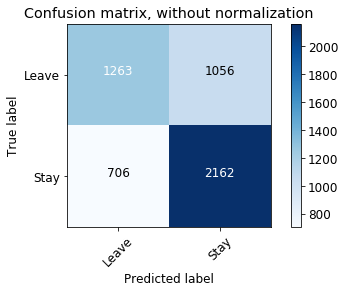

In [129]:
# Plot non-normalized confusion matrix
class_names = ['Leave','Stay']
plt.figure()
plot_confusion_matrix(knn_con_mat,classes=class_names,
                     title='Confusion matrix, without normalization')

Normalized confusion matrix
[[ 0.54463131  0.45536869]
 [ 0.24616457  0.75383543]]


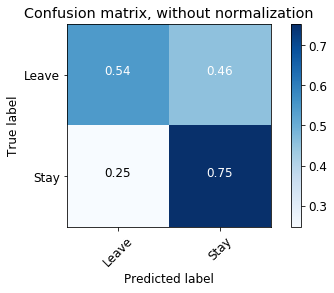

In [130]:
plt.figure()
plot_confusion_matrix(knn_con_mat,classes=class_names,
                      normalize = True,
                     title='Confusion matrix, normalization')

### Precision and Recall

In [131]:
print("Precision:", precision_score(y_dev, y_score))
print("Recall:", recall_score(y_dev, y_score))

Precision: 0.671845866998
Recall: 0.753835425384


### Average Precision and Recall

In [132]:
print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.77


### F1 Score

In [133]:
print("f1 score most frequent: {:.2f}".format(
    f1_score(y_dev, y_score)))

f1 score most frequent: 0.71


In [134]:
knn.score(X_train,y_train)

0.81979674460877472

### Figure out the best k-parameter

In [135]:
from sklearn.model_selection import GridSearchCV

In [136]:
k = np.arange(20)+1
parameters = {'n_neighbors': k}
clf = GridSearchCV(knn, parameters, cv=5)

In [137]:
clf.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [143]:
#%time clf.fit(X_train, y_train)

In [144]:
clf.best_params_

{'n_neighbors': 5}

In [145]:
clf.score(X_train,y_train)

0.77187474179955384

In [146]:
knn2 = KNeighborsClassifier(n_neighbors = 5, algorithm = 'brute')
cross_val_score(knn2, X_train, y_train, cv=5)

array([ 0.64023131,  0.64436183,  0.65840562,  0.6559273 ,  0.63993386])

# = = = = = = = = = = = = = = = = = 
# Niave Bayes Classifier

### Importing the Naive Bayes Classifier

In [148]:
from sklearn.naive_bayes import GaussianNB

### Create a guassian classifier

In [153]:
naive_bayes = GaussianNB()

# Training the model
naive_bayes.fit(X_train, y_train)

GaussianNB(priors=None)

In [156]:
y_score = naive_bayes.predict(X_dev)

### Acuracy on the train and dev set

In [155]:
print("Test set accuracy: {:.2f}".format(naive_bayes.score(X_train, y_train)))
print("Test set accuracy: {:.2f}".format(naive_bayes.score(X_dev, y_dev)))

Test set accuracy: 0.56
Test set accuracy: 0.54


In [157]:
con_mat = confusion_matrix(y_dev, y_score)

Confusion matrix, without normalization
[[1533  786]
 [1605 1263]]


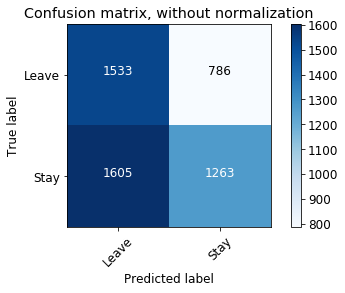

In [165]:
# Plot non-normalized confusion matrix
class_names = ['Leave','Stay']
plt.figure()
plot_confusion_matrix(con_mat,classes=class_names,
                     title='Confusion matrix, without normalization')

Normalized confusion matrix
[[ 0.6610608   0.3389392 ]
 [ 0.55962343  0.44037657]]


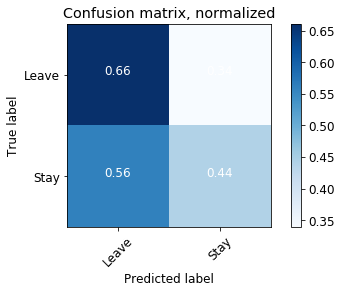

In [164]:
plt.figure()
plot_confusion_matrix(con_mat,classes=class_names,
                      normalize = True,
                     title='Confusion matrix, normalized')

### Precision and recall

In [161]:
print("Precision:", precision_score(y_dev, y_score))
print("Recall:", recall_score(y_dev, y_score))

Precision: 0.616398243045
Recall: 0.440376569038


### F1 Score

In [167]:
print("f1 score most frequent: {:.2f}".format(
    f1_score(y_dev, y_score)))

f1 score most frequent: 0.51


Naive Bayes gives me the worst F1 score yet... possibly because some of the varibales aren't normally distirbuted

# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
# Final Conclusion and Take Aways:

### 1. Salary and Senority have an impact on when employees quit
This was confirmed both through visual inspection of survival plots but also from the Cox proportional hazzard model to analyze survival

### 2. Logistic Regression and Random Forest do a reasonable job predicting who will quit

Logistic Regression F1 Score: .71, Random Forest F1 score: .76

Feature importance in Random Forest confirms the importance of Salary, Senority, and Time on when employees quit

### Suggestions for companies:
Because there is a large drop off in emplyees after year 1 until year 3 companies should put program into place to make sure they are retaining the most talented employees. Moreover, understanding the recruiting practices at other companies and what types of opportunties employyes are leaving for may help companines to put programs in place to retain this young segment of the workforce.